# Taller análisis de crecimiento
Fisiología Vegetal - 2024-01<br>
__Hans D. Escobar H.__

In [13]:
source("main.R")

# plots configuration

# ggplot configuration

theme_set(theme_bw(base_size = 18, base_line_size = 1) +
  theme(
    axis.text = element_text(size = 16),
    text = element_text(size = 18),
    legend.title = element_text(size = 19),
    legend.text = element_text(size = 18)
  ))

plot_base_width <- 15
options(repr.plot.width = plot_base_width)


## 1. Cargar y explorar los datos

In [14]:
data <- read.delim(
  "../Data/FFB.tsv",
  col.names = c("Genotype", "Year", "FFB"),
  colClasses = c("factor", "integer", "double")
)
data %>%
  group_by(Genotype) %>%
  summarize(
    FFB_min = min(FFB), FFB_median = median(FFB), FFB_max = max(FFB),
    Years_min = min(Year), Years_max = max(Year)
  )


Genotype,FFB_min,FFB_median,FFB_max,Years_min,Years_max
<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>
(Djongo x Ekona) x Yangambi,2.2,31.6,35.6,3,11
Deli x AVROS,5.4,34.9,43.8,3,11
Deli x AVROS Dumpy,11.2,32.3,42.5,3,11
Deli x Ghana,7.6,32.4,43.6,3,11
Deli x La Mé,3.9,29.8,34.7,3,11
Deli x Nigeria,8.1,31.1,43.3,3,11
Deli x Yangambi,12.5,31.1,36.8,3,11


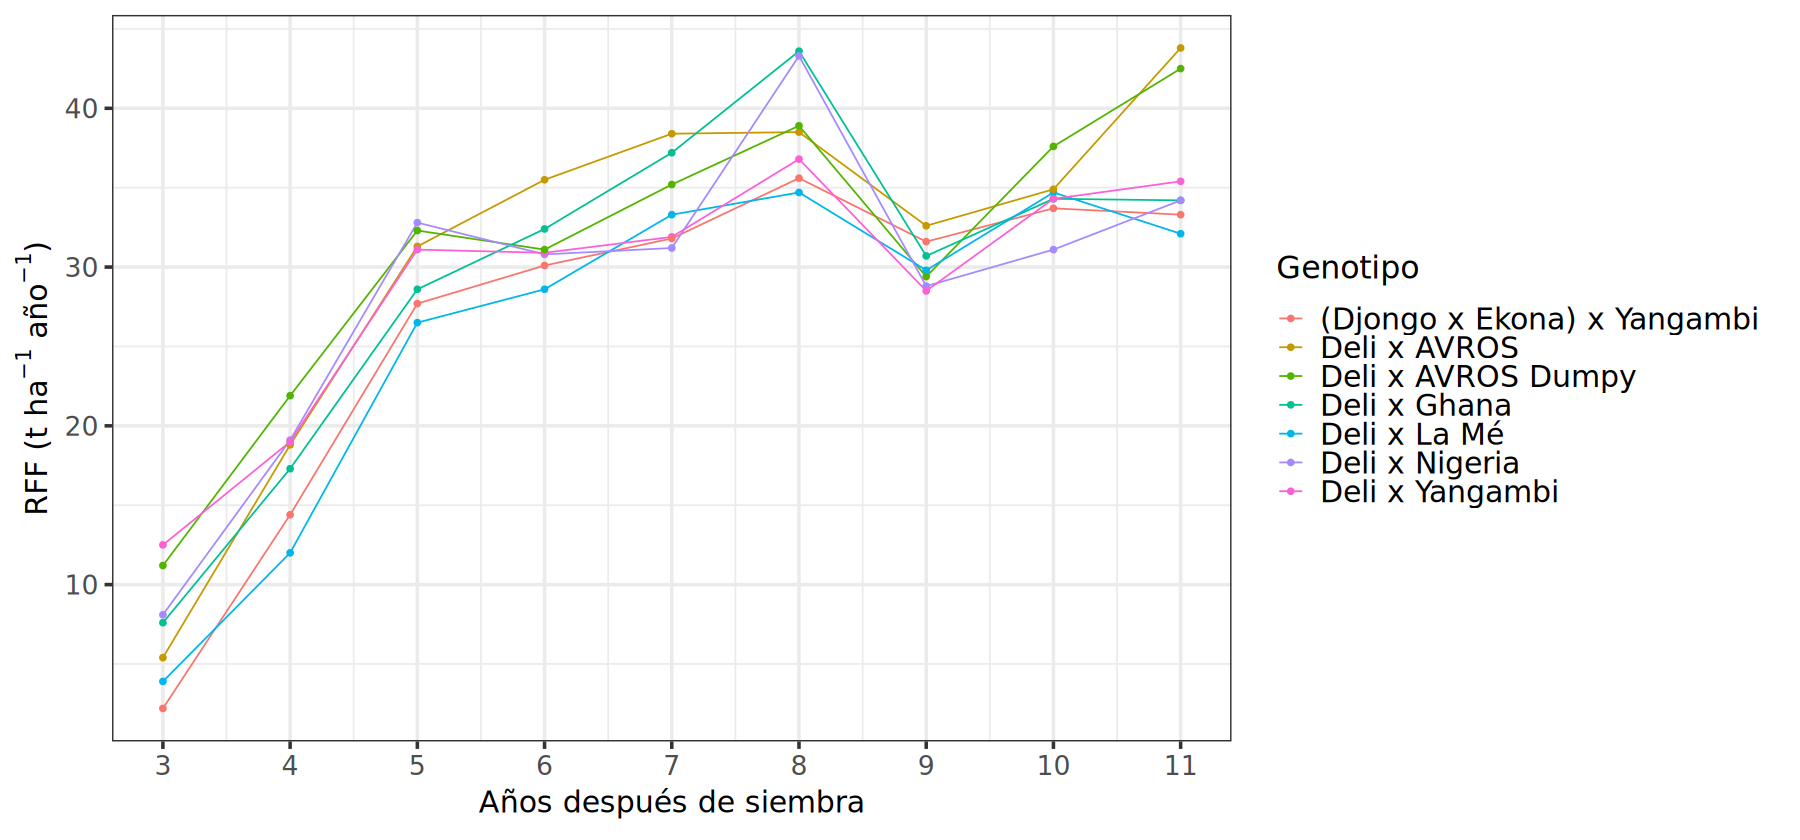

In [15]:
ggplot(
  data = data,
  mapping = aes(x = Year, y = FFB, group = Genotype, color = Genotype)
) +
  geom_line() +
  geom_point() +
  scale_x_continuous(breaks = unique(data$Year)) +
  labs(
    x = expression("Años después de siembra"),
    y = expression("RFF" ~ "(" * t ~ ha^{
      -1
    } ~ año^
      {
        -1
      } * ")"),
    color = expression("Genotipo")
  )


## 2. Identificando el modelo de regresión más apropiado

El coeficiente de determinación $(\mathbf{R}^2)$ __no__ es adecuado para medir la bondad de ajuste de modelos __no__ lineales. En modelos no lineales no se conserva una propiedad que sí tienen los modelos lineales y, en consecuencia, puede tener valores negativos, no es una medida de la variabilidad explicada por el modelo y su uso puede llevar a interpretaciones erradas.

Es más pertinente el uso de otras herramientas tales como el criterio de información de Akaike (AIC) (Burnham & Anderson, 1998) o el pseudo-$\mathbf{R}^2$ (Schabenberger & Pierce, 2001). Tener presente que:

- Sí la razón $\frac{n}{n_{par}} \leq 40$, donde $n$ es el número de observaciones y $n_{par}$ el número de parámetros del modelo, debe usarse el criterio corregido $AICc$ (Burnham & Anderson, 1998).

- Teóricamente, pseudo-$\mathbf{R}^2$ puede tener valores negativos en modelos no lineales. Recordar tambien que no es una medida de variabilidad explicada (Schabenberger & Pierce, 2001).

In [16]:
tested_models <- test_nls_models(
  data,
  group = "Genotype",
  response = "FFB", explanatory = "Year"
)

tested_models[["goodness"]] %>%
  group_by(model) %>%
  summarize(
    AICc_mean = mean(AICc),
    pseudo_R_square_mean = mean(pseudo_R_square),
    significative_proportion_mean = mean(significative_proportion)
  ) %>%
  arrange(AICc_mean, desc(pseudo_R_square_mean))


model,AICc_mean,pseudo_R_square_mean,significative_proportion_mean
<fct>,<dbl>,<dbl>,<dbl>
logistic,55.27976,0.8917893,0.9523810
gompertz,55.41310,0.8885646,0.6190476
asymptotic,57.55046,0.8746574,0.4285714
asymptotic_origin,63.43411,0.6549889,0.7857143


El modelo logístico presenta el menor AICc y el mayor pseudo-$\mathbf{R}^2$, por ambos criterios es modelo con mejor ajuste.

In [17]:
models_to_use <- filter_models(tested_models, "logistic")

data.frame(
  t(sapply(
    names(models_to_use),
    FUN = function(x) {
      p.value <- shapiro.test(residuals(models_to_use[[x]]))[["p.value"]]
      c(
        list(
          Genotype = x,
          shapiro_p.value = p.value,
          PASS = p.value >= 0.05
        ),
        coefficients(models_to_use[[x]])
      )
    }, USE.NAMES = FALSE
  )),
  stringsAsFactors = TRUE
) %>%
  mutate_at("Genotype", function(x) as.factor(unlist(x))) %>%
  mutate_at(2:6, unlist) %>%
  arrange(desc(Asym))


Genotype,shapiro_p.value,PASS,Asym,xmid,scal
<fct>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
Deli x AVROS,0.37621890,TRUE,37.55816,4.020467,0.5981842
Deli x AVROS Dumpy,0.81954995,TRUE,36.67457,3.659416,0.8746044
Deli x Ghana,0.18498702,TRUE,35.92686,4.024487,0.7323117
Deli x Nigeria,0.09308834,TRUE,33.64474,3.744254,0.5748537
Deli x Yangambi,0.76238787,TRUE,33.60207,3.550506,0.8450438
(Djongo x Ekona) x Yangambi,0.52555299,TRUE,32.91185,4.158786,0.5163619
Deli x La Mé,0.40309937,TRUE,32.71657,4.274316,0.6020639


En todos los grupos el error se ajusta a una distribución normal.

## References

Burnham, K. P., & Anderson, D. R. (1998). Practical Use of the Information-Theoretic Approach. In Model Selection and Inference (pp. 75–117). Springer New York. https://doi.org/10.1007/978-1-4757-2917-7_3

Schabenberger, O., & Pierce, F. J. (2001). Nonlinear Models. In Contemporary Statistical Models for the Plant and Soil Sciences (p. 760). CRC Press. https://doi.org/10.1201/9781420040197


